# Fine tuning for image classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Download dataset

https://www.kaggle.com/shashwatwork/knee-osteoarthritis-dataset-with-severity

# Data preprocessing

In [3]:
train_dir = "OA_Knee/train"
validation_dir = "OA_Knee/val"
test_dir = "OA_Knee/test"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.


In [4]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 181
Number of validation batches: 26
Number of test batches: 52


# Show the first nine images and labels from the training set:

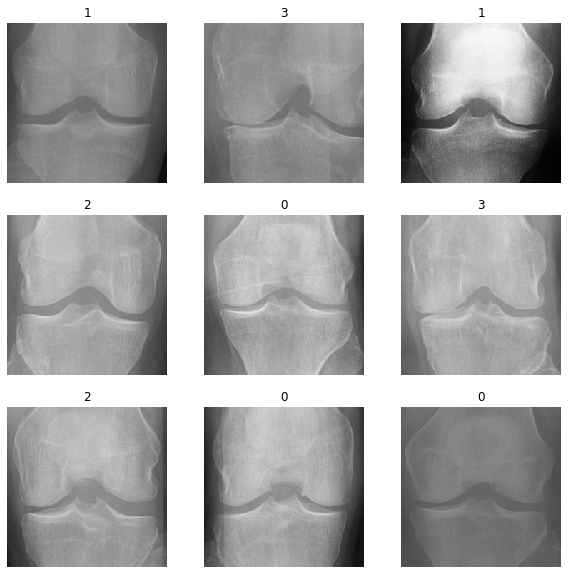

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

https://medium.com/featurepreneur/data-augmentation-using-keras-preprocessing-layers-6cdc7d49328e

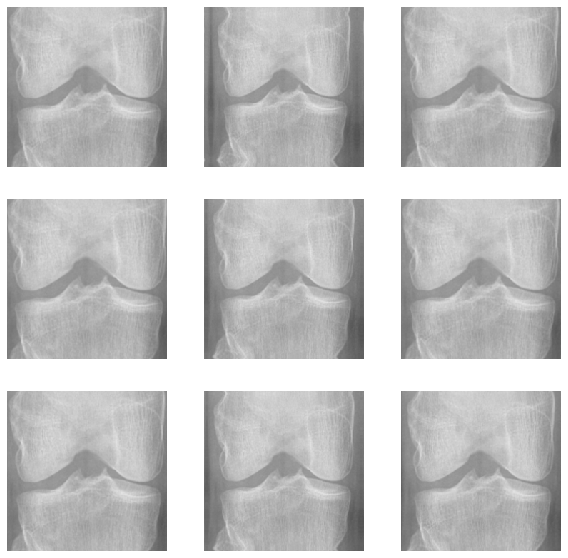

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Rescale pixel values

In [8]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
base_model = tf.keras.models.Model(inputs= base_model.input, outputs=base_model.layers[-5].output)

base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

# Fine turning by adding a classification head

In [13]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  186


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 128, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(32, activation = tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(16, activation = tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax)(x)


model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
model (Functional)           (None, 7, 7, 512)         22505984  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024

# Compile the model

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Train the model

In [17]:
from sklearn.utils import class_weight
y_in_train = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(y_in_train),
                                                 y= y_in_train)
class_weights = dict(enumerate(class_weights))

In [18]:
class_weights

{0: 0.5055118110236221,
 1: 1.1047801147227534,
 2: 0.7622691292875989,
 3: 1.5265521796565389,
 4: 6.679768786127168}

In [19]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
181/181 [==============================] - 138s 693ms/step - loss: 1.5672 - sparse_categorical_accuracy: 0.3292 - val_loss: 1.4105 - val_sparse_categorical_accuracy: 0.4165
Epoch 2/10
181/181 [==============================] - 120s 665ms/step - loss: 1.3418 - sparse_categorical_accuracy: 0.4784 - val_loss: 1.3877 - val_sparse_categorical_accuracy: 0.4322
Epoch 3/10
181/181 [==============================] - 125s 690ms/step - loss: 1.1518 - sparse_categorical_accuracy: 0.5388 - val_loss: 1.2008 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/10
181/181 [==============================] - 135s 731ms/step - loss: 1.0500 - sparse_categorical_accuracy: 0.5687 - val_loss: 1.2452 - val_sparse_categorical_accuracy: 0.4891
Epoch 5/10
181/181 [==============================] - 128s 705ms/step - loss: 0.9397 - sparse_categorical_accuracy: 0.5862 - v

# Learning curves

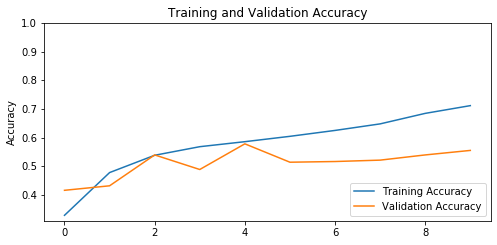

In [20]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluation and prediction

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

52/52 [==============================] - 22s 404ms/step - loss: 1.1398 - sparse_categorical_accuracy: 0.5574
Test accuracy : 0.5573671460151672


In [22]:
pred = model.predict(test_dataset)
pred = np.argmax(pred,axis=1)

In [23]:
y = np.concatenate([y for x, y in test_dataset], axis=0)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y,pred)

array([[278, 146,  78, 120,  17],
       [128,  72,  31,  52,  13],
       [201,  96,  62,  70,  18],
       [ 91,  55,  22,  48,   7],
       [ 24,  11,   7,   4,   5]], dtype=int64)

# Prediction

In [27]:
from tensorflow.keras.preprocessing import image

img = image.load_img('9043446L.png', target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)

pred = np.argmax(prediction,axis=1)

print(pred)

[4]
